In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Download NLTK data if needed
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

print("✅ Bibliothèques importées")

✅ Bibliothèques importées


CHARGEMENT DES DONNÉES

In [3]:
print("\n" + "="*70)
print("CHARGEMENT DES DONNÉES")
print("="*70)

# Charger les données nettoyées du Notebook 1
df = pd.read_csv('DataSet/spam_cleaned.csv')

print(f"Dataset chargé: {df.shape}")
print(f"Colonnes: {df.columns.tolist()}")

# On garde seulement les colonnes essentielles
df_clean = df[['label', 'message']].copy()

print(f"\n✅ {len(df_clean)} messages chargés")
print(f"   - Ham: {len(df_clean[df_clean['label']=='ham'])}")
print(f"   - Spam: {len(df_clean[df_clean['label']=='spam'])}")


CHARGEMENT DES DONNÉES
Dataset chargé: (5169, 7)
Colonnes: ['label', 'message', 'length', 'word_count', 'special_chars', 'digit_count', 'uppercase_count']

✅ 5169 messages chargés
   - Ham: 4516
   - Spam: 653


FONCTIONS DE PREPROCESSING

In [4]:
print("\n" + "="*70)
print("DÉFINITION DES FONCTIONS DE PREPROCESSING")
print("="*70)

# Initialiser les outils NLP
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Fonction de nettoyage de texte
def clean_text(text, remove_stopwords=True, use_lemmatization=True):
    """
    Nettoie le texte pour le Deep Learning
    
    Args:
        text: texte à nettoyer
        remove_stopwords: supprimer les stopwords
        use_lemmatization: utiliser la lemmatisation
    
    Returns:
        texte nettoyé
    """
    # Convertir en minuscules
    text = text.lower()
    
    # Supprimer les URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Supprimer les numéros de téléphone (pattern: +XX XXXXXXXXXX ou XXX-XXX-XXXX)
    text = re.sub(r'\+?\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,9}', '', text)
    
    # Supprimer les emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Garder seulement les lettres et espaces (supprimer ponctuation et chiffres)
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text)
    
    # Tokeniser
    tokens = text.split()
    
    # Supprimer les stopwords si demandé
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation si demandée
    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Supprimer les mots très courts (1-2 lettres)
    tokens = [word for word in tokens if len(word) > 2]
    
    return ' '.join(tokens)

# Fonction pour extraire des features additionnelles
def extract_features(text):
    """
    Extrait des features numériques du texte
    Ces features seront utilisées plus tard pour le modèle multi-input
    """
    features = {}
    
    # Longueur
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    
    # Caractères spéciaux
    features['special_char_count'] = sum(1 for c in text if not c.isalnum() and not c.isspace())
    features['digit_count'] = sum(1 for c in text if c.isdigit())
    features['uppercase_count'] = sum(1 for c in text if c.isupper())
    
    # Ratios
    if len(text) > 0:
        features['special_char_ratio'] = features['special_char_count'] / len(text)
        features['digit_ratio'] = features['digit_count'] / len(text)
        features['uppercase_ratio'] = features['uppercase_count'] / len(text)
    else:
        features['special_char_ratio'] = 0
        features['digit_ratio'] = 0
        features['uppercase_ratio'] = 0
    
    # Mots spammers courants
    spam_words = ['free', 'win', 'winner', 'cash', 'prize', 'urgent', 'call', 'claim']
    text_lower = text.lower()
    features['spam_word_count'] = sum(1 for word in spam_words if word in text_lower)
    
    return features

print("✅ Fonctions définies:")
print("   - clean_text(): Nettoyage du texte")
print("   - extract_features(): Extraction de features numériques")


DÉFINITION DES FONCTIONS DE PREPROCESSING
✅ Fonctions définies:
   - clean_text(): Nettoyage du texte
   - extract_features(): Extraction de features numériques


APPLIQUER LE PREPROCESSING

In [5]:
print("\n" + "="*70)
print("APPLICATION DU PREPROCESSING")
print("="*70)

# Appliquer le nettoyage
print("\nNettoyage des textes en cours...")
df_clean['cleaned_text'] = df_clean['message'].apply(clean_text)

# Extraire les features numériques
print("Extraction des features...")
features_list = df_clean['message'].apply(extract_features)
features_df = pd.DataFrame(features_list.tolist())

# Combiner avec le dataframe principal
df_processed = pd.concat([df_clean, features_df], axis=1)

print(f"\n✅ Preprocessing terminé!")
print(f"Colonnes: {df_processed.columns.tolist()}")

# Afficher quelques exemples
print("\n" + "="*70)
print("EXEMPLES DE TEXTES NETTOYÉS")
print("="*70)

for i in range(3):
    print(f"\n[Exemple {i+1}] - {df_processed.iloc[i]['label'].upper()}")
    print(f"Original: {df_processed.iloc[i]['message'][:100]}...")
    print(f"Nettoyé:  {df_processed.iloc[i]['cleaned_text'][:100]}...")


APPLICATION DU PREPROCESSING

Nettoyage des textes en cours...
Extraction des features...

✅ Preprocessing terminé!
Colonnes: ['label', 'message', 'cleaned_text', 'length', 'word_count', 'special_char_count', 'digit_count', 'uppercase_count', 'special_char_ratio', 'digit_ratio', 'uppercase_ratio', 'spam_word_count']

EXEMPLES DE TEXTES NETTOYÉS

[Exemple 1] - HAM
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got a...
Nettoyé:  jurong point crazy available bugis great world buffet cine got amore wat...

[Exemple 2] - HAM
Original: Ok lar... Joking wif u oni......
Nettoyé:  lar joking wif oni...

[Exemple 3] - SPAM
Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr...
Nettoyé:  free entry wkly comp win cup final tkts may text receive entry question std txt rate apply...


ANALYSE POST-PREPROCESSING


STATISTIQUES POST-PREPROCESSING

Longueur des textes nettoyés (en mots):
        count       mean       std  min   25%   50%   75%   max
label                                                          
ham    4516.0   6.833038  5.370526  0.0   3.0   5.0   9.0  73.0
spam    653.0  12.640123  3.670983  0.0  11.0  13.0  15.0  21.0


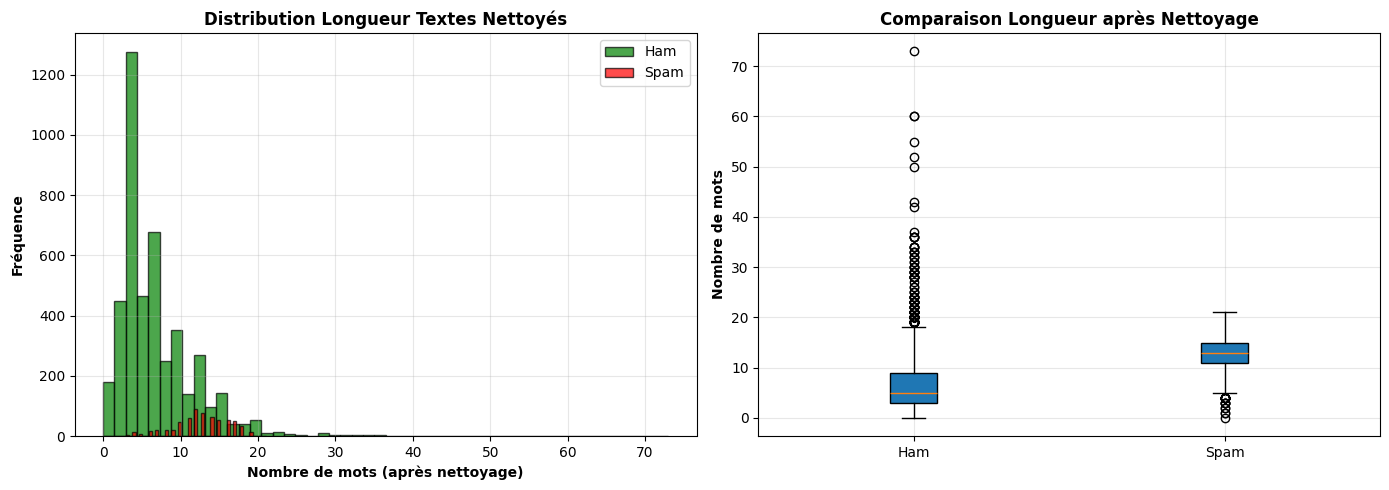

In [6]:
print("\n" + "="*70)
print("STATISTIQUES POST-PREPROCESSING")
print("="*70)

# Longueur des textes nettoyés
df_processed['cleaned_length'] = df_processed['cleaned_text'].apply(len)
df_processed['cleaned_word_count'] = df_processed['cleaned_text'].apply(lambda x: len(x.split()))

print("\nLongueur des textes nettoyés (en mots):")
print(df_processed.groupby('label')['cleaned_word_count'].describe())

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution longueur (mots)
axes[0].hist(df_processed[df_processed['label']=='ham']['cleaned_word_count'], 
             bins=50, alpha=0.7, label='Ham', color='green', edgecolor='black')
axes[0].hist(df_processed[df_processed['label']=='spam']['cleaned_word_count'], 
             bins=50, alpha=0.7, label='Spam', color='red', edgecolor='black')
axes[0].set_xlabel('Nombre de mots (après nettoyage)', fontweight='bold')
axes[0].set_ylabel('Fréquence', fontweight='bold')
axes[0].set_title('Distribution Longueur Textes Nettoyés', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot comparatif
axes[1].boxplot([df_processed[df_processed['label']=='ham']['cleaned_word_count'],
                  df_processed[df_processed['label']=='spam']['cleaned_word_count']],
                labels=['Ham', 'Spam'], patch_artist=True)
axes[1].set_ylabel('Nombre de mots', fontweight='bold')
axes[1].set_title('Comparaison Longueur après Nettoyage', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/preprocessing_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

TOKENISATION (KERAS TOKENIZER)


TOKENISATION AVEC KERAS TOKENIZER

Paramètres:
  - Vocabulary Size: 10000
  - Max Sequence Length: 100
  - OOV Token: <OOV>

✅ Tokenisation terminée!
  - Taille du vocabulaire (effectif): 6707
  - Nombre de séquences: 5169
  - Shape des séquences: (5169, 100)


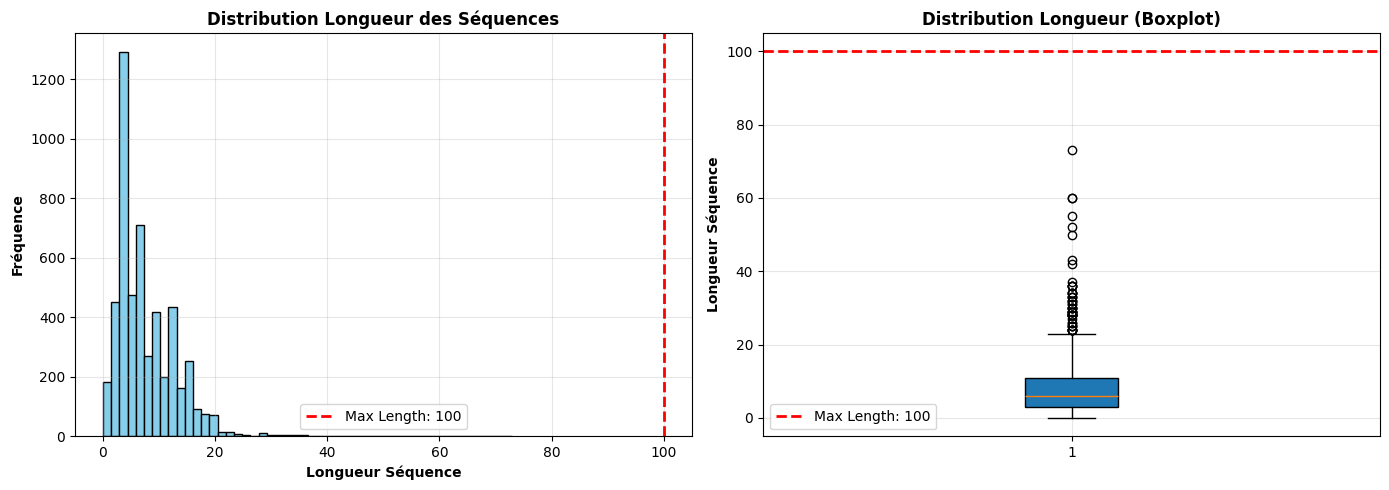


Statistiques longueur séquences:
  - Min: 0
  - Max: 73
  - Moyenne: 7.57
  - Médiane: 6.00
  - % séquences tronquées: 0.00%

EXEMPLES DE TOKENISATION

[Exemple 1]
Texte: jurong point crazy available bugis great world buffet cine got amore wat...
Séquence: [3071, 232, 497, 468, 911, 47, 256, 2113, 912, 9, 3072, 49]...
Padded: [3071  232  497  468  911   47  256 2113  912    9 3072   49    0    0
    0    0    0    0    0    0]...

[Exemple 2]
Texte: lar joking wif oni...
Séquence: [184, 1046, 287, 1367]...
Padded: [ 184 1046  287 1367    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]...

[Exemple 3]
Texte: free entry wkly comp win cup final tkts may text receive entry question std txt ...
Séquence: [4, 364, 747, 689, 102, 913, 498, 2114, 153, 13, 233, 364, 288, 914, 22, 203, 289]...
Padded: [   4  364  747  689  102  913  498 2114  153   13  233  364  288  914
   22  203  289    0    0    0]...


In [7]:
print("\n" + "="*70)
print("TOKENISATION AVEC KERAS TOKENIZER")
print("="*70)

# Paramètres de tokenisation
VOCAB_SIZE = 10000  # Taille du vocabulaire
MAX_LENGTH = 100    # Longueur maximale des séquences
OOV_TOKEN = "<OOV>" # Token pour mots hors vocabulaire

print(f"\nParamètres:")
print(f"  - Vocabulary Size: {VOCAB_SIZE}")
print(f"  - Max Sequence Length: {MAX_LENGTH}")
print(f"  - OOV Token: {OOV_TOKEN}")

# Créer le tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Fit sur tous les textes nettoyés
tokenizer.fit_on_texts(df_processed['cleaned_text'])

# Convertir les textes en séquences
sequences = tokenizer.texts_to_sequences(df_processed['cleaned_text'])

# Padding des séquences
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

print(f"\n✅ Tokenisation terminée!")
print(f"  - Taille du vocabulaire (effectif): {len(tokenizer.word_index)}")
print(f"  - Nombre de séquences: {len(padded_sequences)}")
print(f"  - Shape des séquences: {padded_sequences.shape}")

# Visualiser la distribution de longueur des séquences
seq_lengths = [len([x for x in seq if x != 0]) for seq in padded_sequences]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(seq_lengths, bins=50, color='skyblue', edgecolor='black')
axes[0].axvline(MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max Length: {MAX_LENGTH}')
axes[0].set_xlabel('Longueur Séquence', fontweight='bold')
axes[0].set_ylabel('Fréquence', fontweight='bold')
axes[0].set_title('Distribution Longueur des Séquences', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(seq_lengths, vert=True, patch_artist=True)
axes[1].axhline(MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max Length: {MAX_LENGTH}')
axes[1].set_ylabel('Longueur Séquence', fontweight='bold')
axes[1].set_title('Distribution Longueur (Boxplot)', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/sequence_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nStatistiques longueur séquences:")
print(f"  - Min: {np.min(seq_lengths)}")
print(f"  - Max: {np.max(seq_lengths)}")
print(f"  - Moyenne: {np.mean(seq_lengths):.2f}")
print(f"  - Médiane: {np.median(seq_lengths):.2f}")
print(f"  - % séquences tronquées: {sum(1 for l in seq_lengths if l > MAX_LENGTH) / len(seq_lengths) * 100:.2f}%")

# Afficher quelques exemples de tokenisation
print("\n" + "="*70)
print("EXEMPLES DE TOKENISATION")
print("="*70)

for i in range(3):
    print(f"\n[Exemple {i+1}]")
    print(f"Texte: {df_processed.iloc[i]['cleaned_text'][:80]}...")
    print(f"Séquence: {sequences[i][:20]}...")
    print(f"Padded: {padded_sequences[i][:20]}...")

ENCODAGE DES LABELS

In [8]:
print("\n" + "="*70)
print("ENCODAGE DES LABELS")
print("="*70)

# Encoder les labels: ham=0, spam=1
label_mapping = {'ham': 0, 'spam': 1}
labels = df_processed['label'].map(label_mapping).values

print(f"✅ Labels encodés:")
print(f"  - ham → 0")
print(f"  - spam → 1")
print(f"  - Shape: {labels.shape}")
print(f"  - Distribution: Ham={np.sum(labels==0)}, Spam={np.sum(labels==1)}")


ENCODAGE DES LABELS
✅ Labels encodés:
  - ham → 0
  - spam → 1
  - Shape: (5169,)
  - Distribution: Ham=4516, Spam=653


SPLIT TRAIN/VALIDATION/TEST

In [9]:
print("\n" + "="*70)
print("SPLIT DES DONNÉES")
print("="*70)

# Split strategy: 70% train, 15% validation, 15% test
X = padded_sequences
y = labels

# First split: 70% train, 30% temp (for val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (50-50 split of the 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"✅ Split terminé:")
print(f"  - Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"    Ham: {np.sum(y_train==0)}, Spam: {np.sum(y_train==1)}")
print(f"  - Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"    Ham: {np.sum(y_val==0)}, Spam: {np.sum(y_val==1)}")
print(f"  - Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"    Ham: {np.sum(y_test==0)}, Spam: {np.sum(y_test==1)}")



SPLIT DES DONNÉES
✅ Split terminé:
  - Train: 3618 samples (70.0%)
    Ham: 3161, Spam: 457
  - Validation: 775 samples (15.0%)
    Ham: 677, Spam: 98
  - Test: 776 samples (15.0%)
    Ham: 678, Spam: 98


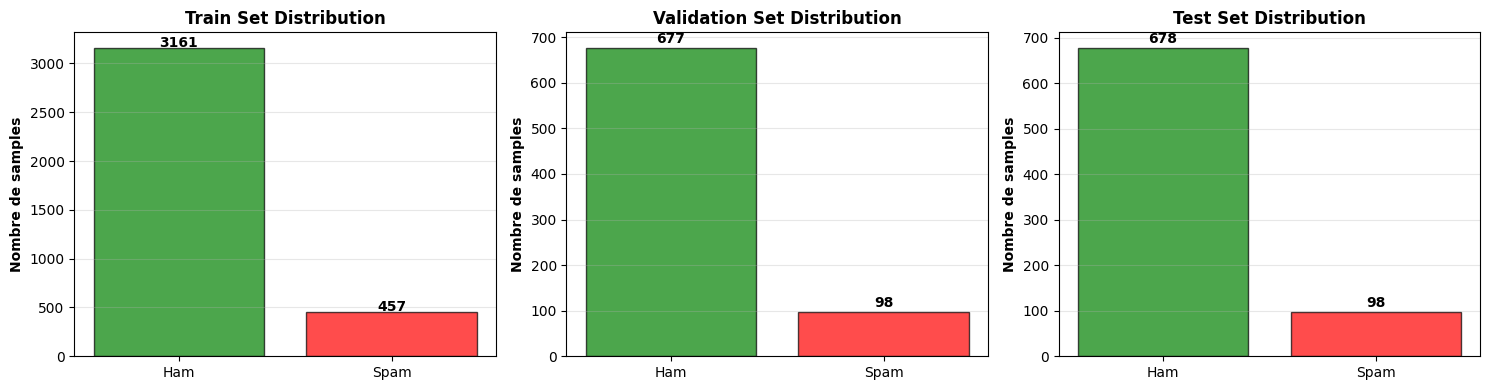

In [10]:
# Visualisation de la distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

splits = [
    ('Train', y_train),
    ('Validation', y_val),
    ('Test', y_test)
]

for ax, (name, split_y) in zip(axes, splits):
    counts = [np.sum(split_y==0), np.sum(split_y==1)]
    ax.bar(['Ham', 'Spam'], counts, color=['green', 'red'], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Nombre de samples', fontweight='bold')
    ax.set_title(f'{name} Set Distribution', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs
    for i, v in enumerate(counts):
        ax.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('results/train_val_test_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

CLASS WEIGHTS (Pour gérer le déséquilibre)


In [11]:
print("\n" + "="*70)
print("CALCUL DES CLASS WEIGHTS")
print("="*70)

# Calculer les class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"✅ Class Weights calculés:")
print(f"  - Ham (0): {class_weight_dict[0]:.4f}")
print(f"  - Spam (1): {class_weight_dict[1]:.4f}")
print(f"\n💡 Ces weights seront utilisés pendant l'entraînement pour compenser le déséquilibre")


CALCUL DES CLASS WEIGHTS
✅ Class Weights calculés:
  - Ham (0): 0.5723
  - Spam (1): 3.9584

💡 Ces weights seront utilisés pendant l'entraînement pour compenser le déséquilibre


PRÉPARER LES FEATURES NUMÉRIQUES (Pour modèle multi-input plus tard)

In [12]:
print("\n" + "="*70)
print("PRÉPARATION DES FEATURES NUMÉRIQUES")
print("="*70)

# Sélectionner les features numériques
numeric_features = ['length', 'word_count', 'special_char_count', 'digit_count', 
                    'uppercase_count', 'special_char_ratio', 'digit_ratio', 
                    'uppercase_ratio', 'spam_word_count']

X_numeric = df_processed[numeric_features].values

# Normaliser les features (StandardScaler)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Split les features numériques aussi
X_numeric_train = X_numeric_scaled[:len(X_train)]
X_numeric_val = X_numeric_scaled[len(X_train):len(X_train)+len(X_val)]
X_numeric_test = X_numeric_scaled[len(X_train)+len(X_val):]

print(f"✅ Features numériques préparées:")
print(f"  - Features: {numeric_features}")
print(f"  - Shape: {X_numeric_scaled.shape}")
print(f"  - Train: {X_numeric_train.shape}")
print(f"  - Val: {X_numeric_val.shape}")
print(f"  - Test: {X_numeric_test.shape}")


PRÉPARATION DES FEATURES NUMÉRIQUES
✅ Features numériques préparées:
  - Features: ['length', 'word_count', 'special_char_count', 'digit_count', 'uppercase_count', 'special_char_ratio', 'digit_ratio', 'uppercase_ratio', 'spam_word_count']
  - Shape: (5169, 9)
  - Train: (3618, 9)
  - Val: (775, 9)
  - Test: (776, 9)


SAUVEGARDER LES DONNÉES PRÉPROCESSÉES

In [16]:
print("\n" + "="*70)
print("SAUVEGARDE DES DONNÉES PRÉPROCESSÉES")
print("="*70)

# Sauvegarder avec numpy
np.save('DataSet/X_train.npy', X_train)
np.save('DataSet/X_val.npy', X_val)
np.save('DataSet/X_test.npy', X_test)
np.save('DataSet/y_train.npy', y_train)
np.save('DataSet/y_val.npy', y_val)
np.save('DataSet/y_test.npy', y_test)

# Sauvegarder les features numériques
np.save('DataSet/X_numeric_train.npy', X_numeric_train)
np.save('DataSet/X_numeric_val.npy', X_numeric_val)
np.save('DataSet/X_numeric_test.npy', X_numeric_test)

# Sauvegarder le tokenizer
import pickle
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Sauvegarder le scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Sauvegarder les paramètres
params = {
    'vocab_size': VOCAB_SIZE,
    'max_length': MAX_LENGTH,
    'oov_token': OOV_TOKEN,
    'class_weights': class_weight_dict,
    'numeric_features': numeric_features
}

with open('models/preprocessing_params.pkl', 'wb') as f:
    pickle.dump(params, f)

print("✅ Fichiers sauvegardés:")
print("  - data/X_train.npy, X_val.npy, X_test.npy")
print("  - data/y_train.npy, y_val.npy, y_test.npy")
print("  - data/X_numeric_train.npy, X_numeric_val.npy, X_numeric_test.npy")
print("  - models/tokenizer.pkl")
print("  - models/scaler.pkl")
print("  - models/preprocessing_params.pkl")



SAUVEGARDE DES DONNÉES PRÉPROCESSÉES
✅ Fichiers sauvegardés:
  - data/X_train.npy, X_val.npy, X_test.npy
  - data/y_train.npy, y_val.npy, y_test.npy
  - data/X_numeric_train.npy, X_numeric_val.npy, X_numeric_test.npy
  - models/tokenizer.pkl
  - models/scaler.pkl
  - models/preprocessing_params.pkl


RÉSUMÉ FINAL

In [18]:
print("\n" + "="*70)
print("RÉSUMÉ DU PREPROCESSING")
print("="*70)

print(f"""
 DONNÉES PRÉPARÉES:
   - Dataset original: {len(df_processed)} messages
   - Vocabulary size: {len(tokenizer.word_index)}
   - Max sequence length: {MAX_LENGTH}
   
 SPLITS:
   - Train: {len(X_train)} samples (70%)
   - Validation: {len(X_val)} samples (15%)
   - Test: {len(X_test)} samples (15%)
   
 CLASS WEIGHTS:
   - Ham (0): {class_weight_dict[0]:.4f}
   - Spam (1): {class_weight_dict[1]:.4f}
   
 FEATURES:
   - Séquences tokenisées: shape {X_train.shape}
   - Features numériques: {len(numeric_features)} features
   
 TRANSFORMATIONS APPLIQUÉES:
   1. Nettoyage du texte (lowercase, remove URLs, emails, phone)
   2. Suppression des stopwords
   3. Lemmatisation
   4. Tokenisation avec Keras Tokenizer
   5. Padding des séquences
   6. Normalisation des features numériques
   7. Encodage des labels (ham=0, spam=1)
   
 PROCHAINES ÉTAPES:
   ✓ Preprocessing terminé
   → Notebook 3: Entraînement modèles classiques (LSTM, GRU, CNN)
""")

print("="*70)
print("✅ PREPROCESSING TERMINÉ!")
print("="*70)


RÉSUMÉ DU PREPROCESSING

 DONNÉES PRÉPARÉES:
   - Dataset original: 5169 messages
   - Vocabulary size: 6707
   - Max sequence length: 100

 SPLITS:
   - Train: 3618 samples (70%)
   - Validation: 775 samples (15%)
   - Test: 776 samples (15%)

 CLASS WEIGHTS:
   - Ham (0): 0.5723
   - Spam (1): 3.9584

 FEATURES:
   - Séquences tokenisées: shape (3618, 100)
   - Features numériques: 9 features

 TRANSFORMATIONS APPLIQUÉES:
   1. Nettoyage du texte (lowercase, remove URLs, emails, phone)
   2. Suppression des stopwords
   3. Lemmatisation
   4. Tokenisation avec Keras Tokenizer
   5. Padding des séquences
   6. Normalisation des features numériques
   7. Encodage des labels (ham=0, spam=1)

 PROCHAINES ÉTAPES:
   ✓ Preprocessing terminé
   → Notebook 3: Entraînement modèles classiques (LSTM, GRU, CNN)

✅ PREPROCESSING TERMINÉ!
